# ROME PROJECT
###### Daniel Elechiguerra Batlle

I have coded the general parameters so that only the cells that have assignments need to be changed.

As for the algorithms, changing the parameters that appear at the beginning of the cell should be enough and it should run automatically without the need to change anything else. You can also optimize the hyperparameters by: **Grid Search, Random Search, Bayesian Optimization y Genetic Algorithms**.

Parameters and results for **MLP, GRU, RNN y LSTM (y BI-LSTM)** are automatically logged in **"Results1.xlsx"** in order to being able of comparing results. **CNN** usses different hyperparameters and should be saved independently. 
Currently, I am saving (but this information could be expanded if necessary):


> *Algorithm,	Layers,	Neurons per layer,	Activation,	Optimizer,	Learning rate,, Horizon,	Back steps,	Batch size,	Epochs,	Dataset,	Learning MSE,	Validation MSE,	Traning time*


##### Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import sklearn
import time
import re
import random as rn
import json
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Conv1D, Flatten, Dropout, MaxPooling1D, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor



from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/ROME

"""
4/0wEsu7nRb_dx7NWjv0t3zL8OqMRNzfoHu9ZKz6EXmbPwq8TQBvVIi6Y
"""

Mounted at /content/drive
/content/drive/My Drive/ROME


'\n4/0wEsu7nRb_dx7NWjv0t3zL8OqMRNzfoHu9ZKz6EXmbPwq8TQBvVIi6Y\n'

##### Select working dataset

In [ ]:
dataset = '1h' # Choose 15min (more samples) or 1h (less samples)

##### Aux Functions (No debería hacer falta modificar nada aquí)

In [ ]:
# This function transforms the input set into 2D/3D inputs
# 3D: (samples, back_steps, features)
# 2D: (samples, back_steps*features)

def create_dataset(old_x, old_y, back_steps = 1, horizon = 1, task = '3d'):
    
    new_x, new_y = pd.DataFrame(), pd.DataFrame()
    for i in range(1, back_steps + 1):
        columns = []
        for column in list(old_x.columns):
            columns.append(column + ' - ' + str(i))
        new_x[columns] = old_x.shift(i)
        new_x['y - ' + str(i)] = old_y.shift(i)
    new_x = new_x[back_steps + horizon - 1:].reset_index(drop = True)
    new_y = old_y[back_steps + horizon - 1:].reset_index(drop = True)
    if task == '3d':
        return np.array(new_x).reshape((np.array(new_x).shape[0], back_steps, int(np.array(new_x).shape[1]/back_steps))), np.array(new_y)
    elif task == '2d':
        return new_x, new_y
    
    return

In [ ]:
# Load data (careful with the loading if next function is moved to a different script)

data = pd.read_csv('TTOTdataEEM17v3.csv', index_col = 0).reset_index(drop = True)
data['Date'] = pd.to_datetime(data['Date'])

if dataset == '15min': 
    data.drop(['Date', 'Hour', 'Min'], axis = 1, inplace = True)
    x = data.iloc[:,:-1]
    x = x[x.columns[1::3]]
    y = pd.DataFrame(data.iloc[:,-1])
else: 
    data_hour = data.groupby(by = ['Date', 'Hour']).mean()
    data_hour = data_hour.reset_index(drop = True)
    x = data_hour.iloc[:,:-1]
    x = x[x.columns[1::3]]
    y = pd.DataFrame(data_hour.iloc[:,-1])
    
def prepare_data(task = '3d', back_steps = 1, horizon = 1, test_size = 0.2, shuffle = False):

    # Train / Test
    if shuffle:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 42)
    else:
        x_train = x.iloc[:int((1 - test_size)*len(x)),:]
        x_test = x.iloc[int((1 - test_size)*len(x)):,:]
        y_train = y.iloc[:int((1 - test_size)*len(y)),:]
        y_test = y.iloc[int((1 - test_size)*len(y)):,:].reset_index(drop = True)

    # Scale input
    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
    x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
    
    # Scale output
    
    # Create dataset
    if task == '3d':
        x_train, y_train = create_dataset(x_train, y_train, back_steps, horizon, '3d')
        x_test, y_test = create_dataset(x_test, y_test, back_steps, horizon, '3d')
    elif task == '2d':
        x_train, y_train = create_dataset(x_train, y_train, back_steps, horizon, '2d')
        x_test, y_test = create_dataset(x_test, y_test, back_steps, horizon, '2d')
    
    return x_train, y_train, x_test, y_test

In [ ]:
seed = 1234

def set_seed(seed = seed):
    
    import os
    import tensorflow as tf

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

### Deep Learning Models

###### Select General Parameters 

In [ ]:
# General Parameters
back_steps = 10
horizon = 1

##### Benchmark MSE

In [ ]:
# Error of predicting the same output as the last interval value can be used as benchmark

x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)
mse_benchmark = sklearn.metrics.mean_squared_error(y_test[horizon:], y_test[:y_test.shape[0] - horizon])
print('Benchmark MSE:', mse_benchmark)

Benchmark MSE: 272.83736866408935


##### MLP 

In [ ]:
set_seed()

# Network parameters
neurons_per_layer = [32, 32]
epochs = 30
batch_size = 50
learning_rate = 0.0005
opt = keras.optimizers.Adam(lr = learning_rate) #Se puede cambiar Adam por cualquier otro
act = 'relu'
verbose = 0



# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon, activation = act)

# Create an empty model
model = Sequential()

# Add layers
model.add(Dense(neurons_per_layer[0], input_dim = x_train.shape[1]))
for neurons in neurons_per_layer[1:]:
    model.add(Dense(neurons, activation = act))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer = opt)

# Fit model on the dataset
start_time = time.time()
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = verbose, shuffle = False)
training_time = time.time() - start_time

# Evaluate model
y_pred = model.predict(x_test)
mlp_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('MLP MSE:', mlp_mse)

# Save results
results = pd.read_excel('Results.xlsx')
results.loc[len(results)] = ['mlp', len(neurons_per_layer), neurons_per_layer[0], act, str(opt)[18:re.search(r'\b(object)\b', str(opt)).start()-1].lower(), learning_rate, horizon, back_steps, batch_size, epochs, dataset, history.history['loss'][-1], mlp_mse, training_time]
results.to_excel('Results.xlsx', index = False)

MLP MSE: 260.54733222449914


#### GRU

In [ ]:
set_seed()

# Network parameters
neurons_per_layer = [20, 20, 20] 
epochs = 20
batch_size = 20
learning_rate = 0.0005
opt = keras.optimizers.Adam(lr = learning_rate) #Se puede cambiar Adam por cualquier otro
act = 'relu'
verbose = 0

# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# Create an empty model
model = Sequential()

# Add layers
if len(neurons_per_layer) == 1:
    model.add(GRU(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False, activation = act))
else:
    model.add(GRU(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True, activation = act))
    for neurons in neurons_per_layer[1:-1]:
        model.add(GRU(neurons, return_sequences = True, activation = act))
    model.add(GRU(neurons_per_layer[-1], return_sequences = False, activation = act))
model.add(Dense(1))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = opt)

# Fit model on the dataset
start_time = time.time()
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = verbose, shuffle = False)
training_time = time.time() - start_time

# Evaluate model
y_pred = model.predict(x_test)
gru_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('GRU MSE:', gru_mse)

# Save results
results = pd.read_excel('Results.xlsx')
results.loc[len(results)] = ['gru', len(neurons_per_layer), neurons_per_layer[0], act, str(opt)[18:re.search(r'\b(object)\b', str(opt)).start()-1].lower(), learning_rate, horizon, back_steps, batch_size, epochs, dataset, history.history['loss'][-1], gru_mse, training_time]
results.to_excel('Results.xlsx', index = False)

GRU MSE: 297.2388861765779


#### LSTM

In [ ]:
set_seed()

# Network parameters
neurons_per_layer = [20, 20, 20, 20] #[20,20,20,20], batch 20 y adam daba buenos resultados para el dataset corto
epochs = 20
batch_size = 20
learning_rate = 0.0005
opt = keras.optimizers.Adam(lr = learning_rate) #Se puede cambiar Adam por cualquier otro
act = 'elu'
verbose = 0



# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# Create an empty model
model = Sequential()

# Add layers
if len(neurons_per_layer) == 1:
    model.add(LSTM(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False, activation = act))
else:
    model.add(LSTM(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True, activation = act))
    for neurons in neurons_per_layer[1:-1]:
        model.add(LSTM(neurons, return_sequences = True, activation = act))
    model.add(LSTM(neurons_per_layer[-1], return_sequences = False, activation = act))
model.add(Dense(1))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = opt)

# Fit model on the dataset
start_time = time.time()
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = verbose, shuffle = False)
training_time = time.time() - start_time

# Evaluate model
y_pred = model.predict(x_test)
lstm_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('LSTM MSE:', lstm_mse)

# Save results
results = pd.read_excel('Results.xlsx')
results.loc[len(results)] = ['lstm', len(neurons_per_layer), neurons_per_layer[0], act, str(opt)[18:re.search(r'\b(object)\b', str(opt)).start()-1].lower(), learning_rate, horizon, back_steps, batch_size, epochs, dataset, history.history['loss'][-1], lstm_mse, training_time]
results.to_excel('Results.xlsx', index = False)

LSTM MSE: 337.25699268763856


#### Bidirectional LSTM

In [ ]:
set_seed()

# Network parameters
neurons_per_layer = [20, 20, 20] #Usa las mismas neuronas en un sentido y en otro, pero se podría cambiar
epochs = 10
batch_size = 20
learning_rate = 0.002
opt = keras.optimizers.Adam(lr = learning_rate) #Se puede cambiar Adam por cualquier otro
act = 'elu'
verbose = 0



# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# Create an empty model
model = Sequential()

# Add layers
if len(neurons_per_layer) == 1:
    model.add(Bidirectional(LSTM(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False, activation = act)))
else:
    model.add(Bidirectional(LSTM(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True, activation = act)))
    for neurons in neurons_per_layer[1:-1]:
        model.add(Bidirectional(LSTM(neurons, return_sequences = True, activation = act)))
    model.add(Bidirectional(LSTM(neurons_per_layer[-1], return_sequences = False, activation = act)))
model.add(Dense(1))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = opt)

# Fit model on the dataset
start_time = time.time()
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = verbose, shuffle = False)
training_time = time.time() - start_time

# Evaluate model
y_pred = model.predict(x_test)
bilstm_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('Bidirectional LSTM MSE:', bilstm_mse)

# Save results
results = pd.read_excel('Results.xlsx')
results.loc[len(results)] = ['bilstm', len(neurons_per_layer), neurons_per_layer[0], act, str(opt)[18:re.search(r'\b(object)\b', str(opt)).start()-1].lower(), learning_rate, horizon, back_steps, batch_size, epochs, dataset, history.history['loss'][-1], bilstm_mse, training_time]
results.to_excel('Results.xlsx', index = False)

Bidirectional LSTM MSE: 307.5186695196177


#### RNN

In [ ]:
set_seed()

# Network parameters
neurons_per_layer = [20, 20, 20, 20]
epochs = 10
batch_size = 20
learning_rate = 0.00025
opt = keras.optimizers.Adam(lr = learning_rate) #Se puede cambiar Adam por cualquier otro
act = 'relu'
verbose = 0



# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# Create an empty model
model = Sequential()

# Add layers
if len(neurons_per_layer) == 1:
    model.add(SimpleRNN(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False, activation = act))
else:
    model.add(SimpleRNN(neurons_per_layer[0], input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = True, activation = act))
    for neurons in neurons_per_layer[1:-1]:
        model.add(SimpleRNN(neurons, return_sequences = True, activation = act))
    model.add(SimpleRNN(neurons_per_layer[-1], return_sequences = False, activation = act))
model.add(Dense(1))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = opt)

# Fit model on the dataset
start_time = time.time()
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = verbose, shuffle = False)
training_time = time.time() - start_time

# Evaluate model
y_pred = model.predict(x_test)
rnn_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('RNN MSE:', rnn_mse)

# Save results
results = pd.read_excel('Results.xlsx')
results.loc[len(results)] = ['rnn', len(neurons_per_layer), neurons_per_layer[0], act, str(opt)[18:re.search(r'\b(object)\b', str(opt)).start()-1].lower(), learning_rate, horizon, back_steps, batch_size, epochs, dataset, history.history['loss'][-1], rnn_mse, training_time]
results.to_excel('Results.xlsx', index = False)

RNN MSE: 193.3218933236604


#### Convolutional 1D

In [ ]:
set_seed()

# Network parameters
filters_per_layer = [64,32]
neurons_per_layer = [64,32]
epochs = 10
batch_size = 20
opt = keras.optimizers.Adam(lr = 0.0001) #Se puede cambiar Adam por cualquier otro
act = 'relu'
kernel_size = 3
dropout = 0
pool_size = 1
verbose = 0



# Prepare data
x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# Create an empty model
model = Sequential()

# Add layers
model.add(Conv1D(filters = filters_per_layer[0], input_shape = (x_train.shape[1],x_train.shape[2]), kernel_size = kernel_size, activation = act))
for filters in filters_per_layer[1:]:
    model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = act))
model.add(Dropout(dropout))
model.add(MaxPooling1D(pool_size = pool_size))
model.add(Flatten())
for neurons in neurons_per_layer:
    model.add(Dense(neurons, activation = act))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer = opt)

# Fit model on the dataset
history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_test, y_test), verbose = verbose, shuffle = False)

# Evaluate model
y_pred = model.predict(x_test)
conv1d_mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
print('CNN 1D MSE:', conv1d_mse)

Train on 7022 samples, validate on 1752 samples
Epoch 1/10
7022/7022 [==============================] - 1s 122us/step - loss: 1093.9076 - val_loss: 681.1134
Epoch 2/10
7022/7022 [==============================] - 1s 98us/step - loss: 384.5637 - val_loss: 533.4707
Epoch 3/10
7022/7022 [==============================] - 1s 98us/step - loss: 290.1146 - val_loss: 413.9079
Epoch 4/10
7022/7022 [==============================] - 1s 97us/step - loss: 225.0589 - val_loss: 338.0838
Epoch 5/10
7022/7022 [==============================] - 1s 94us/step - loss: 196.8618 - val_loss: 288.7762
Epoch 6/10
7022/7022 [==============================] - 1s 97us/step - loss: 174.8544 - val_loss: 260.0953
Epoch 7/10
7022/7022 [==============================] - 1s 96us/step - loss: 165.7632 - val_loss: 243.7285
Epoch 8/10
7022/7022 [==============================] - 1s 94us/step - loss: 154.3409 - val_loss: 246.2355
Epoch 9/10
7022/7022 [==============================] - 1s 98us/step - loss: 151.6481 - val_lo

### Analyze results

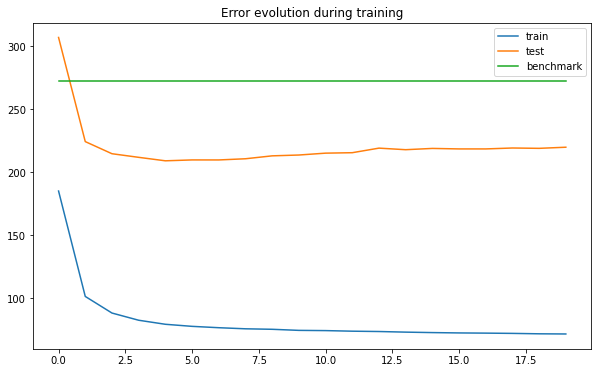

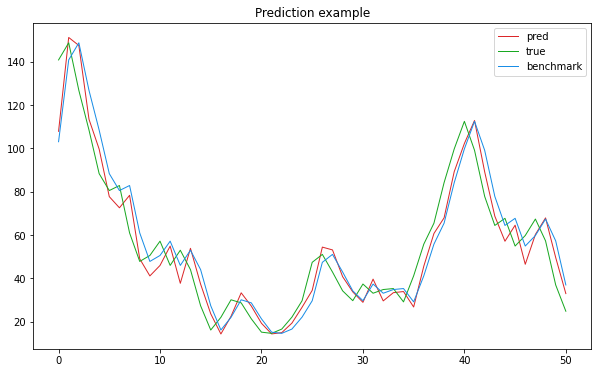

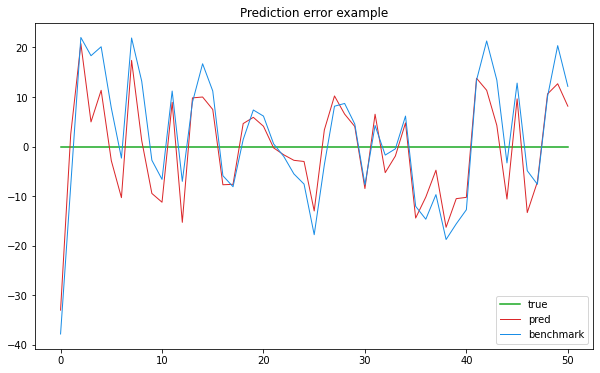

In [ ]:
plt.figure(figsize = (10,6))
plt.title('Error evolution during training')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.plot(np.ones(epochs) * mse_benchmark, label = 'benchmark', c = '#18a821')
plt.legend()
plt.show()

first = 100
last = 150

plt.figure(figsize = (10,6))
plt.plot(y_pred[first:last+1], label = 'pred', c = '#db272a', lw = 1)
plt.title('Prediction example')
plt.plot(np.array(y_test)[first:last+1], label = 'true', c = '#18a821', lw = 1)
plt.plot(np.concatenate(([[None]]*horizon, y_test[:y_test.shape[0] - horizon]))[first:last+1], label = 'benchmark', c = '#198de6', lw = 1)
plt.legend()
plt.show()

plt.figure(figsize = (10,6))
plt.title('Prediction error example')
plt.plot(np.zeros(last-first+1), label = 'true', c = '#18a821')
plt.plot(y_pred[first:last+1]-np.array(y_test)[first:last+1], label = 'pred', c = '#db272a', lw = 1)
plt.plot(np.concatenate(([[None]]*horizon, y_test[:y_test.shape[0] - horizon]))[first:last+1]-np.array(y_test)[first:last+1], label = 'benchmark', c = '#198de6', lw = 1)
plt.legend()
plt.show()

### Hyperparameter Optimization
##### Es necesario correr la celda de "Define Models" para cualquier optimización porque ahí se define la arquitectura de la red

#### Define Models

##### MLP, GRU, RNN, LSTM, BI LSTM

In [ ]:
def create_model(algorithm, activation, optimizer, learning_rate, layers, neurons_per_layer, shape):

    # Layer hyperparameters and number of layers  
    neurons_per_layer = [int(neurons_per_layer)]*int(layers)  

    # Optimizer
    if optimizer == 'adam':
      opt = keras.optimizers.Adam(lr = learning_rate)
    elif optimizer == 'nadam':
      opt = keras.optimizers.Nadam(lr = learning_rate)
    elif optimizer == 'adadelta':
      opt = keras.optimizers.Adadelta(lr = learning_rate)
    elif optimizer == 'adagrad':
      opt = keras.optimizers.Adagrad(lr = learning_rate)
    elif optimizer == 'rmsprop':
      opt = keras.optimizers.RMSprop(lr = learning_rate)

    ## MODEL
    model = Sequential()

    if algorithm == 'mlp':
      # Add layers
      model.add(Dense(neurons_per_layer[0], input_dim = shape[1], activation = activation)) 
      for neurons in neurons_per_layer[1:]:
          model.add(Dense(neurons, activation = activation))
      model.add(Dense(1))

    elif algorithm == 'rnn':
      # Add layers
      if len(neurons_per_layer) == 1:
          model.add(SimpleRNN(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = False, activation = activation))
      else:
          model.add(SimpleRNN(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = True, activation = activation))
          for neurons in neurons_per_layer[1:-1]:
              model.add(SimpleRNN(neurons, return_sequences = True, activation = activation))
          model.add(SimpleRNN(neurons_per_layer[-1], return_sequences = False, activation = activation))
      model.add(Dense(1))

    elif algorithm == 'gru':
      # Add layers
      if len(neurons_per_layer) == 1:
          model.add(GRU(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = False, activation = activation))
      else:
          model.add(GRU(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = True, activation = activation))
          for neurons in neurons_per_layer[1:-1]:
              model.add(GRU(neurons, return_sequences = True, activation = activation))
          model.add(GRU(neurons_per_layer[-1], return_sequences = False, activation = activation))
      model.add(Dense(1))

    elif algorithm == 'lstm':
      # Add layers
      if len(neurons_per_layer) == 1:
          model.add(LSTM(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = False, activation = activation))
      else:
          model.add(LSTM(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = True, activation = activation))
          for neurons in neurons_per_layer[1:-1]:
              model.add(LSTM(neurons, return_sequences = True, activation = activation))
          model.add(LSTM(neurons_per_layer[-1], return_sequences = False, activation = activation))
      model.add(Dense(1))

    elif algorithm == 'bilstm':
      # Add layers
      if len(neurons_per_layer) == 1:
          model.add(Bidirectional(LSTM(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = False, activation = activation)))
      else:
          model.add(Bidirectional(LSTM(neurons_per_layer[0], input_shape = (shape[1], shape[2]), return_sequences = True, activation = activation)))
          for neurons in neurons_per_layer[1:-1]:
              model.add(Bidirectional(LSTM(neurons, return_sequences = True, activation = activation)))
          model.add(Bidirectional(LSTM(neurons_per_layer[-1], return_sequences = False, activation = activation)))
      model.add(Dense(1))

    # Compile model
    model.compile(loss = 'mean_squared_error', optimizer = opt)

    return model

##### Conv1D

In [ ]:
def create_cnn(activation, optimizer, learning_rate, filter_layers, filters_per_layer, neuron_layers, neurons_per_layer, kernel_size, pool_size, dropout, shape):

    # Layer hyperparameters and number of layers  
    neurons_per_layer = [int(neurons_per_layer)]*int(neuron_layers)  
    filters_per_layer = [int(filters_per_layer)]*int(filter_layers)  

    # Optimizer
    if optimizer == 'adam':
      opt = keras.optimizers.Adam(lr = learning_rate)
    elif optimizer == 'nadam':
      opt = keras.optimizers.Nadam(lr = learning_rate)
    elif optimizer == 'adadelta':
      opt = keras.optimizers.Adadelta(lr = learning_rate)
    elif optimizer == 'adagrad':
      opt = keras.optimizers.Adagrad(lr = learning_rate)
    elif optimizer == 'rmsprop':
      opt = keras.optimizers.RMSprop(lr = learning_rate)

    # Create an empty model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters = filters_per_layer[0], input_shape = (shape[1],shape[2]), kernel_size = kernel_size, activation = activation))

    for filters in filters_per_layer[1:]:
        model.add(Conv1D(filters = filters, kernel_size = kernel_size, activation = activation))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(Flatten())
    for neurons in neurons_per_layer:
        model.add(Dense(neurons, activation = activation))
    model.add(Dense(1))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer = optimizer)

    return model

#### Grid Search

##### GRU, RNN, LSTM, BI LSTM

In [ ]:
# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'algorithm' : ['gru'], #['gru', 'rnn', 'lstm', 'bilstm'],
            'activation' : ['elu'], #['elu', 'relu', 'selu']
            'layers' : list(np.arange(1,5,1)), #min_layers, max_layers (no incluido), step_size
            'neurons_per_layer' : list(np.arange(16, 28, 4)), #min_neurons, max_neurons (no incluido), step_size
            'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 5))), #min_lr, max_lr (incluido), number_of_elements
            'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : [20],
            'epochs' : [20]}






x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_model, shape = x_train.shape, verbose = 0)

grid_model = GridSearchCV(estimator = model, param_grid = grid, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error',  return_train_score = True, 
                          cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# save results
results = pd.read_excel('Results1.xlsx')
for i in range(0,len(grid_model.cv_results_['mean_test_score'])):
  results.loc[len(results)] = [grid_model.cv_results_['params'][i]['algorithm'], int(grid_model.cv_results_['params'][i]['layers']), int(grid_model.cv_results_['params'][i]['neurons_per_layer']), 
                              grid_model.cv_results_['params'][i]['activation'], grid_model.cv_results_['params'][i]['optimizer'], grid_model.cv_results_['params'][i]['learning_rate'], 
                              horizon, back_steps, grid_model.cv_results_['params'][i]['batch_size'],grid_model.cv_results_['params'][i]['epochs'], dataset, -grid_model.cv_results_['mean_train_score'][i], -grid_model.cv_results_['mean_test_score'][i], grid_model.cv_results_['mean_fit_time'][i]]
results.to_excel('Results1.xlsx', index = False)

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  5.9min finished


Best MSE:  172.14781082137594
Params:  {'activation': 'elu', 'algorithm': 'gru', 'layers': 2, 'learning_rate': 0.0005000000000000001, 'neurons_per_layer': 24, 'optimizer': 'adam'}


##### Conv1D

In [ ]:
# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'activation' : ['relu'], #['elu', 'relu', 'selu']
        'kernel_size' : [1,2,3,4],
        'pool_size' : [1,2],
        'dropout': [0],
        'neuron_layers' : list(np.arange(1,4,1)), #min_layers, max_layers (no incluido), step_size
        'neurons_per_layer' : list(np.arange(16, 36, 4)), #min_neurons, max_neurons (no incluido), step_size
        'filter_layers' : list(np.arange(1,4,1)), #min_layers, max_layers (no incluido), step_size
        'filters_per_layer' : list(np.arange(16, 36, 4)), #min_neurons, max_neurons (no incluido), step_size
        'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 5))), #min_lr, max_lr (incluido), number_of_elements
        'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
        'batch_size' : [20],
        'epochs' : [20]}



x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_cnn, shape = x_train.shape, verbose = 0)

grid_model = GridSearchCV(estimator = model, param_grid = grid, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error',  return_train_score = True, 
                          cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# los resultados se pueden sacar de grid_model.cv_results_

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)


Fitting 1 folds for each of 5 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


Best MSE:  253.96121603042695
Params:  {'activation': 'relu', 'batch_size': 20, 'dropout': 0, 'epochs': 20, 'filter_layers': 1, 'filters_per_layer': 32, 'kernel_size': 3, 'learning_rate': 0.0028117066259517455, 'neuron_layers': 1, 'neurons_per_layer': 32, 'optimizer': 'adam', 'pool_size': 2}


##### MLP

In [ ]:
# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'algorithm' : ['mlp'],
            'activation' : ['elu'], #['elu', 'relu', 'selu', ]
            'layers' : list(np.arange(1,5,1)), #min_layers, max_layers (no incluido), step_size
            'neurons_per_layer' : list(np.arange(16, 28, 4)), #min_neurons, max_neurons (no incluido), step_size
            'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 5))), #min_lr, max_lr (incluido), number_of_elements
            'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : [20],
            'epochs' : [20]}





x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_model, shape = x_train.shape, verbose = 0)

grid_model = GridSearchCV(estimator = model, param_grid = grid, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error', return_train_score = True,
                          cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# save results
results = pd.read_excel('Results1.xlsx')
for i in range(0,len(grid_model.cv_results_['mean_test_score'])):
  results.loc[len(results)] = [grid_model.cv_results_['params'][i]['algorithm'], int(grid_model.cv_results_['params'][i]['layers']), int(grid_model.cv_results_['params'][i]['neurons_per_layer']), 
                              grid_model.cv_results_['params'][i]['activation'], grid_model.cv_results_['params'][i]['optimizer'], grid_model.cv_results_['params'][i]['learning_rate'], 
                              horizon, back_steps, grid_model.cv_results_['params'][i]['batch_size'],grid_model.cv_results_['params'][i]['epochs'], dataset, -grid_model.cv_results_['mean_train_score'][i], -grid_model.cv_results_['mean_test_score'][i], grid_model.cv_results_['mean_fit_time'][i]]
results.to_excel('Results1.xlsx', index = False)

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.3min finished


Best MSE:  235.1434952721103
Params:  {'activation': 'elu', 'algorithm': 'mlp', 'layers': 2, 'learning_rate': 0.005, 'neurons_per_layer': 16, 'optimizer': 'adam'}


#### Random Search

##### GRU, RNN, LSTM, BI LSTM

In [ ]:
iterations = 20

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'algorithm' : ['gru'], #['gru', 'rnn', 'lstm', 'bilstm'],
            'activation' : ['elu'], #['elu', 'relu', 'selu', ]
            'layers' : list(np.arange(1,6,1)), #min_layers, max_layers (no incluido), step_size
            'neurons_per_layer' : list(np.arange(16, 34, 2)), #min_neurons, max_neurons (no incluido), step_size
            'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 50))), #min_lr, max_lr (incluido), number_of_elements
            'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : [20],
            'epochs' : [20]}





x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_model, shape = x_train.shape, verbose = 0)

grid_model = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = iterations, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error',  
                                return_train_score = True, cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# save results
results = pd.read_excel('Results1.xlsx')
for i in range(0,len(grid_model.cv_results_['mean_test_score'])):
  results.loc[len(results)] = [grid_model.cv_results_['params'][i]['algorithm'], int(grid_model.cv_results_['params'][i]['layers']), int(grid_model.cv_results_['params'][i]['neurons_per_layer']), 
                              grid_model.cv_results_['params'][i]['activation'], grid_model.cv_results_['params'][i]['optimizer'], grid_model.cv_results_['params'][i]['learning_rate'], 
                              horizon, back_steps, grid_model.cv_results_['params'][i]['batch_size'],grid_model.cv_results_['params'][i]['epochs'], dataset, -grid_model.cv_results_['mean_train_score'][i], -grid_model.cv_results_['mean_test_score'][i], grid_model.cv_results_['mean_fit_time'][i]]
results.to_excel('Results1.xlsx', index = False)

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  5.4min finished


Best MSE:  186.2228491198188
Params:  {'optimizer': 'adam', 'neurons_per_layer': 22, 'learning_rate': 0.0020474575311902133, 'layers': 1, 'algorithm': 'gru', 'activation': 'elu'}


##### Conv1D

In [ ]:
iterations = 20

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'activation' : ['relu', 'elu', 'selu'], #['elu', 'relu', 'selu']
        'kernel_size' : [1,2,3,4],
        'pool_size' : [1,2],
        'dropout': [0],
        'neuron_layers' : list(np.arange(1,4,1)), #min_layers, max_layers (no incluido), step_size
        'neurons_per_layer' : list(np.arange(16, 36, 4)), #min_neurons, max_neurons (no incluido), step_size
        'filter_layers' : list(np.arange(1,4,1)), #min_layers, max_layers (no incluido), step_size
        'filters_per_layer' : list(np.arange(16, 36, 4)), #min_neurons, max_neurons (no incluido), step_size
        'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 100))), #min_lr, max_lr (incluido), number_of_elements
        'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
        'batch_size' : [20],
        'epochs' : [20]}



x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_cnn, shape = x_train.shape, verbose = 0)

grid_model = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = iterations, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error',  
                                return_train_score = True, cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# los resultados se pueden sacar de grid_model.cv_results_

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)

Fitting 1 folds for each of 4 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   40.5s finished


Best MSE:  229.97884839444086
Params:  {'pool_size': 1, 'optimizer': 'adam', 'neurons_per_layer': 32, 'neuron_layers': 2, 'learning_rate': 0.0010772173450159421, 'kernel_size': 1, 'filters_per_layer': 16, 'filter_layers': 2, 'epochs': 20, 'dropout': 0, 'batch_size': 20, 'activation': 'elu'}


##### MLP

In [ ]:
iterations = 100

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
grid = {'algorithm' : ['mlp'],
            'activation' : ['elu'], #['elu', 'relu', 'selu', ]
            'layers' : list(np.arange(1,6,1)), #min_layers, max_layers (no incluido), step_size
            'neurons_per_layer' : list(np.arange(16, 34, 2)), #min_neurons, max_neurons (no incluido), step_size
            'learning_rate' : list(np.exp(np.linspace(np.log(0.0005),np.log(0.005), 50))), #min_lr, max_lr (incluido), number_of_elements
            'optimizer' : ['adam'], #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : [20],
            'epochs' : [20]}




x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)

# create model
model = KerasRegressor(build_fn = create_model, shape = x_train.shape, verbose = 0)

grid_model = RandomizedSearchCV(estimator = model, param_distributions = grid, n_iter = iterations, verbose = 1, refit = False, n_jobs = -1, pre_dispatch = '2*n_jobs', scoring = 'neg_mean_squared_error', 
                                return_train_score = True, cv = [(list(np.arange(0,x_train.shape[0],1)),list(np.arange(x_train.shape[0], x_train.shape[0]+x_test.shape[0],1)))])
grid_result = grid_model.fit(np.concatenate((x_train, x_test)),np.concatenate((y_train, y_test)))

# save results
results = pd.read_excel('Results1.xlsx')
for i in range(0,len(grid_model.cv_results_['mean_test_score'])):
  results.loc[len(results)] = [grid_model.cv_results_['params'][i]['algorithm'], int(grid_model.cv_results_['params'][i]['layers']), int(grid_model.cv_results_['params'][i]['neurons_per_layer']), 
                              grid_model.cv_results_['params'][i]['activation'], grid_model.cv_results_['params'][i]['optimizer'], grid_model.cv_results_['params'][i]['learning_rate'], 
                              horizon, back_steps, grid_model.cv_results_['params'][i]['batch_size'],grid_model.cv_results_['params'][i]['epochs'], dataset, -grid_model.cv_results_['mean_train_score'][i], -grid_model.cv_results_['mean_test_score'][i], grid_model.cv_results_['mean_fit_time'][i]]
results.to_excel('Results1.xlsx', index = False)

print('Best MSE: ', -grid_model.best_score_)
print('Params: ', grid_model.best_params_)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Best MSE:  229.25732460916112
Params:  {'optimizer': 'adam', 'neurons_per_layer': 24, 'learning_rate': 0.0006628556827950549, 'layers': 5, 'algorithm': 'mlp', 'activation': 'elu'}


#### Bayesian Optimization

##### MLP, GRU, RNN, LSTM, BI LSTM

In [ ]:
from hyperopt import hp, fmin, tpe, space_eval, Trials

max_evals = 100

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
space = {'algorithm' : hp.choice('algorithm', ['mlp', 'gru', 'rnn', 'lstm', 'bilstm']), #['mlp', 'gru', 'rnn', 'lstm', 'bilstm'],
            'activation' : hp.choice('activation',['elu', 'selu']), #['elu', 'relu', 'selu', ]
            'layers' : hp.quniform('layers', 1, 5, 1), #min_layers, max_layers, step_size
            'neurons_per_layer' : hp.quniform('neurons_per_layer', 16, 64, 2), #min_neurons, max_neurons, step_size
            'learning_rate' : hp.loguniform('learning_rate', np.log(0.00005), np.log(0.005)), #min_lr, max_lr
            'optimizer' : hp.choice('optimizer',['adam']), #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : hp.choice('batch_size',[20]),
            'epochs' : hp.choice('epochs',[20])}
         
# Se puede incluir en las iteraciones el dropout

def objective(params):
    try:
      set_seed()

      # Prepare data
      if params['algorithm'] == 'mlp':
        x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)
      else:
        x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

      model = create_model(algorithm = params['algorithm'], layers = int(params['layers']), neurons_per_layer = int(params['neurons_per_layer']),
                           activation = params['activation'], optimizer = params['optimizer'], learning_rate = params['learning_rate'], shape = x_train.shape)

      # Fit model on the dataset
      start_time = time.time()
      history = model.fit(x_train, y_train, epochs = int(params['epochs']), batch_size = int(params['batch_size']), validation_data = None, verbose = 0, shuffle = False)
      training_time = time.time() - start_time

      # Evaluate model
      y_pred = model.predict(x_test)
      mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

      results = pd.read_excel('Results.xlsx')
      results.loc[len(results)] = [params['algorithm'], int(params['layers']), int(params['neurons_per_layer']), params['activation'], 
                                   params['optimizer'], params['learning_rate'], horizon, back_steps, int(params['batch_size']), int(params['epochs']), dataset, history.history['loss'][-1], mse, training_time]
      results.to_excel('Results.xlsx', index = False)

    except:
      mse = 1000000.0     
      results = pd.read_excel('Results.xlsx')
      results.loc[len(results)] = [params['algorithm'], int(params['layers']), int(params['neurons_per_layer']), params['activation'], 
                                   params['optimizer'], params['learning_rate'], horizon, back_steps, int(params['batch_size']), int(params['epochs']), dataset, 'error', 'error', 'error']
      results.to_excel('Results.xlsx', index = False)

    return mse     #Minimize

trials = Trials()
best = fmin(fn = objective, space = space, max_evals = max_evals, algo = tpe.suggest, trials = trials)
print('\n', best)

100%|██████████| 5/5 [01:18<00:00, 15.64s/it, best loss: 194.28315121675038]

 {'activation': 1, 'algorithm': 1, 'batch_size': 0, 'epochs': 0, 'layers': 1.0, 'learning_rate': 0.0016285422992886756, 'neurons_per_layer': 8.0, 'optimizer': 0}


In [ ]:
from hyperopt import hp, fmin, tpe, space_eval, Trials

max_evals = 5

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
space = {'algorithm' : hp.choice('algorithm', ['mlp']), #['mlp', 'gru', 'rnn', 'lstm', 'bilstm'],
            'activation' : hp.choice('activation',['elu', 'selu']), #['elu', 'relu', 'selu', ]
            'layers' : hp.quniform('layers', 1, 5, 1), #min_layers, max_layers, step_size
            'neurons_per_layer' : hp.quniform('neurons_per_layer', 16, 64, 2), #min_neurons, max_neurons, step_size
            'learning_rate' : hp.loguniform('learning_rate', np.log(0.00005), np.log(0.005)), #min_lr, max_lr
            'optimizer' : hp.choice('optimizer',['adam']), #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
            'batch_size' : hp.choice('batch_size',[20]),
            'epochs' : hp.choice('epochs',[20])}
         
# Se puede incluir en las iteraciones el dropout

def objective(params):
    try:
      set_seed()

      # Prepare data
      if params['algorithm'] == 'mlp':
        x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)
      else:
        x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

      model = create_model(algorithm = params['algorithm'], layers = int(params['layers']), neurons_per_layer = int(params['neurons_per_layer']),
                           activation = params['activation'], optimizer = params['optimizer'], learning_rate = params['learning_rate'], shape = x_train.shape)

      # Fit model on the dataset
      start_time = time.time()
      history = model.fit(x_train, y_train, epochs = int(params['epochs']), batch_size = int(params['batch_size']), validation_data = None, verbose = 0, shuffle = False)
      training_time = time.time() - start_time

      # Evaluate model
      y_pred = model.predict(x_test)
      mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

      results = pd.read_excel('Results.xlsx')
      results.loc[len(results)] = [params['algorithm'], int(params['layers']), int(params['neurons_per_layer']), params['activation'], 
                                   params['optimizer'], params['learning_rate'], horizon, back_steps, int(params['batch_size']), int(params['epochs']), dataset, history.history['loss'][-1], mse, training_time]
      results.to_excel('Results.xlsx', index = False)

    except:
      mse = 1000000.0     
      results = pd.read_excel('Results.xlsx')
      results.loc[len(results)] = [params['algorithm'], int(params['layers']), int(params['neurons_per_layer']), params['activation'], 
                                   params['optimizer'], params['learning_rate'], horizon, back_steps, int(params['batch_size']), int(params['epochs']), dataset, 'error', 'error', 'error']
      results.to_excel('Results.xlsx', index = False)

    return mse     #Minimize

trials = Trials()
best = fmin(fn = objective, space = space, max_evals = max_evals, algo = tpe.suggest, trials = trials)
print('\n', best)

100%|██████████| 5/5 [00:47<00:00,  9.57s/it, best loss: 247.19572752773777]

 {'activation': 0, 'algorithm': 0, 'batch_size': 0, 'epochs': 0, 'layers': 3.0, 'learning_rate': 0.0002205873175762452, 'neurons_per_layer': 26.0, 'optimizer': 0}


##### Conv1D

In [ ]:
from hyperopt import hp, fmin, tpe, space_eval, Trials

max_evals = 100

# Hiperparámetros a optimizar. Se pueden seleccionar uno o varios algoritmos!
space = {'activation' : hp.choice('activation', ['relu', 'elu', 'selu']), #['elu', 'relu', 'selu']
          'kernel_size' : hp.choice('kernel_size', [1,2,3,4]),
          'pool_size' : hp.choice('pool_size', [1,2]),
          'dropout': hp.choice('dropout', [0]),
          'neuron_layers' : hp.quniform('neuron_layers', 1, 5, 1), #min_layers, max_layers, step_size
          'neurons_per_layer' : hp.quniform('neurons_per_layer', 16, 64, 2), #min_neurons, max_neurons, step_size
          'filter_layers' : hp.quniform('filter_layers', 1, 5, 1), #min_layers, max_layers, step_size
          'filters_per_layer' : hp.quniform('filters_per_layer', 16, 64, 2), #min_filters, max_filters, step_size
          'learning_rate' : hp.loguniform('learning_rate', np.log(0.00005), np.log(0.005)), #min_lr, max_lr
          'optimizer' : hp.choice('optimizer', ['adam']), #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
          'batch_size' : hp.choice('batch_size', [20]),
          'epochs' : hp.choice('epochs', [20])}


# Se puede incluir en las iteraciones el dropout

def objective(params):
    try:
      set_seed()

      # Prepare data
      x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)
      
      model = create_cnn(neuron_layers = int(params['neuron_layers']), neurons_per_layer = int(params['neurons_per_layer']), filter_layers = int(params['filter_layers']), filters_per_layer = int(params['filters_per_layer']),
                          activation = params['activation'], optimizer = params['optimizer'], learning_rate = params['learning_rate'], kernel_size = params['kernel_size'], pool_size = params['pool_size'], 
                          dropout = params['dropout'], shape = x_train.shape)
      
      # Fit model on the dataset
      start_time = time.time()
      history = model.fit(x_train, y_train, epochs = int(params['epochs']), batch_size = int(params['batch_size']), validation_data = None, verbose = 0, shuffle = False)
      training_time = time.time() - start_time

      # Evaluate model
      y_pred = model.predict(x_test)
      mse = sklearn.metrics.mean_squared_error(y_test, y_pred)
      print(mse)
      print(params,'\n')
    except Exception as e:
      #print(e)
      mse = 1000000.0     

    return mse     #Minimize

trials = Trials()
best = fmin(fn = objective, space = space, max_evals = max_evals, algo = tpe.suggest, trials = trials)
print('\n', best)

260.5823332790841
{'activation': 'elu', 'batch_size': 20, 'dropout': 0, 'epochs': 20, 'filter_layers': 1.0, 'filters_per_layer': 18.0, 'kernel_size': 2, 'learning_rate': 0.0008293693930353605, 'neuron_layers': 2.0, 'neurons_per_layer': 20.0, 'optimizer': 'adam', 'pool_size': 2}
289.97567020812755
{'activation': 'relu', 'batch_size': 20, 'dropout': 0, 'epochs': 20, 'filter_layers': 2.0, 'filters_per_layer': 16.0, 'kernel_size': 1, 'learning_rate': 0.0003036735905865056, 'neuron_layers': 1.0, 'neurons_per_layer': 18.0, 'optimizer': 'adam', 'pool_size': 1}
252.1951413849477
{'activation': 'elu', 'batch_size': 20, 'dropout': 0, 'epochs': 20, 'filter_layers': 1.0, 'filters_per_layer': 18.0, 'kernel_size': 3, 'learning_rate': 0.0016795474791795142, 'neuron_layers': 2.0, 'neurons_per_layer': 20.0, 'optimizer': 'adam', 'pool_size': 1}
233.1937728157367
{'activation': 'relu', 'batch_size': 20, 'dropout': 0, 'epochs': 20, 'filter_layers': 1.0, 'filters_per_layer': 18.0, 'kernel_size': 3, 'learni

#### Genetic Algorithms

##### MLP, GRU, RNN, LSTM, BI LSTM

In [ ]:
def fit_model(algorithm, activation, optimizer, learning_rate, layers, neurons_per_layer, batch_size, epochs):

    set_seed()

    if algorithm == 'mlp':
      x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)
    else:
      x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)
    
    model = create_model(algorithm = algorithm, activation = activation, optimizer = optimizer, learning_rate = learning_rate, 
                         layers = layers, neurons_per_layer = neurons_per_layer, shape = x_train.shape)
    
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = None, verbose = 0, shuffle = False)
    training_time = time.time() - start_time
    
    return model, history.history['loss'][-1], training_time


class Network():
    def __init__(self):
        #self._epochs = np.random.randint(10, 20)
        #self._batch_size = np.random.randint(10, 25)
        self._epochs = epochs
        self._batch_size = batch_size

        self._algorithm = rn.choice(['mlp']) #['mlp', 'gru', 'rnn', 'lstm', 'bilstm']

        self._layers = np.random.randint(1, 6)
        self._neurons_per_layer = 10 + 2 * np.random.randint(1, 28)

        self._activation = rn.choice(['elu']) #['relu', 'elu', 'selu']
        self._optimizer = rn.choice(['adam']) #['adam', 'nadam', 'adadelta', 'adagrad', 'rmsprop']
        self._learning_rate = np.exp(np.log(0.0005) + np.random.rand() * (np.log(0.005) - np.log(0.0005)))

        self._mse = 1000000

    def init_hyperparams(self):
        hyperparams = {
            'epochs': self._epochs,
            'batch_size': self._batch_size,
            'algorithm': self._algorithm,
            'layers': self._layers,
            'neurons_per_layer': self._neurons_per_layer,
            'activation': self._activation,
            'optimizer': self._optimizer,
            'learning_rate': self._learning_rate
        }
        return hyperparams

def init_networks(population):
    return [Network() for _ in range(population)]
def fitness_network(network):

    hyperparams = network.init_hyperparams()
    epochs = hyperparams['epochs']
    batch_size = hyperparams['batch_size']
    algorithm = hyperparams['algorithm']
    layers = hyperparams['layers']
    neurons_per_layer = hyperparams['neurons_per_layer']
    activation = hyperparams['activation']
    optimizer = hyperparams['optimizer']
    learning_rate = hyperparams['learning_rate']
    
    try:
        model, training_error, training_time = fit_model(algorithm = algorithm, activation = activation, optimizer = optimizer, learning_rate = learning_rate,
                                                          layers = layers, neurons_per_layer = neurons_per_layer, batch_size = batch_size, epochs = epochs)
        
        if algorithm == 'mlp':
          x_train, y_train, x_test, y_test = prepare_data(task = '2d', back_steps = back_steps, horizon = horizon)
        else:
          x_train, y_train, x_test, y_test = prepare_data(task = '3d', back_steps = back_steps, horizon = horizon)

        y_pred = model.predict(x_test)
        mse = sklearn.metrics.mean_squared_error(y_test, y_pred)

        results = pd.read_excel('Results.xlsx')
        results.loc[len(results)] = [algorithm, int(layers), int(neurons_per_layer), activation, optimizer, learning_rate, horizon, back_steps, batch_size, epochs, dataset,
                                      training_error, mse, training_time]
        results.to_excel('Results.xlsx', index = False)

        network._mse = mse
        print ('MSE: {}'.format(network._mse))

    except:
        network._mse = 1000000
        results = pd.read_excel('Results.xlsx')
        results.loc[len(results)] = [algorithm, int(layers), int(neurons_per_layer), activation, optimizer, learning_rate, horizon, back_steps, batch_size, epochs, dataset,
                                      'error', 'error', 'error']
        results.to_excel('Results.xlsx', index = False)
        print ('Error')

    return network

def fitness(networks, parallelization = False):
    if parallelization:
      n_networks = Parallel(n_jobs=-1)(delayed(fitness_network)(network) for network in networks)
      for network in n_networks:
        print ('MSE: {}'.format(network._mse))
    else:
      n_networks = []
      for network in networks:
        n_networks.append(fitness_network(network))
    return n_networks

def selection(networks):
    networks = sorted(networks, key=lambda network: network._mse, reverse=False)
    networks = networks[:int(0.2 * len(networks)) + 2]

    return networks

def crossover(networks):
    offspring = []
    for _ in range(int((population - len(networks)) / 2)):
        parent1 = rn.choice(networks)
        parent2 = rn.choice(networks)
        child1 = Network()
        child2 = Network()

        # Crossing over parent hyper-params
        child1._epochs = parent2._epochs #max(int(3*parent1._epochs/4 + parent2._epochs/4),10)
        child2._epochs = parent1._epochs #max(int(parent1._epochs/4 + 3*parent2._epochs/4),10)

        child1._batch_size = parent2._batch_size #max(int(parent1._batch_size/4) + 3*parent2._batch_size/4),10)
        child2._batch_size = parent1._batch_size #max(int(3*parent1._batch_size/4) + parent2._batch_size/4),10)

        child1._algorithm = parent2._algorithm
        child2._algorithm = parent1._algorithm        
        
        child1._layers = rn.choice([parent1._layers, parent2._layers]) #max(int(3*parent1._layers/4 + parent2._layers/4),1)
        child2._layers = rn.choice([parent1._layers, parent2._layers]) #max(int(parent1._layers/4 + 3*parent2._layers/4),1)

        child1._neurons_per_layer = max(int(parent1._neurons_per_layer/4 + 3*parent2._neurons_per_layer/4), 8)
        child2._neurons_per_layer = max(int(3*parent1._neurons_per_layer/4 + parent2._neurons_per_layer/4), 8)

        child1._activation = parent2._activation
        child2._activation = parent1._activation

        child1._optimizer = parent1._optimizer
        child2._optimizer = parent2._optimizer

        child1._learning_rate = parent1._learning_rate
        child2._learning_rate = parent2._learning_rate

        offspring.append(child1)
        offspring.append(child2)

    networks.extend(offspring)

    return networks

def mutate(networks):
    for network in networks:
        if np.random.uniform(0, 1) <= 0.1:
            #network._epochs += 5 * np.random.randint(0,3)
            #network._batch_size += 5 * np.random.randint(0,3)
            network._layers += rn.choice([0,1,1,2])
            network._neurons_per_layer += 2 * np.random.randint(0,9)
            network._learning_rate *= (0.8 + 0.4 * np.random.rand())

    return networks

In [ ]:
batch_size = 20
epochs = 20
threshold = 170
generations = 4
population = 20
parallelization = True #Colab solo tiene 2 cores

networks = init_networks(population)
best_mse = np.inf
best_network = None

for gen in range(generations):
    print ('\nGeneration {}'.format(gen+1))
    networks = fitness(networks, parallelization)
    networks = selection(networks)
    networks = crossover(networks)
    networks = mutate(networks)

    for network in networks:
        if network._mse < best_mse:
          best_network = network
          best_mse = network._mse 

    if best_mse < threshold:
        print ('\nThreshold met')
        break

   
print ('\n' + str(best_network.init_hyperparams()))
print ('Best MSE: {}'.format(best_network._mse))


Generation 1
MSE: 269.6067938435947
MSE: 302.2831096490641
MSE: 287.64192564320956
MSE: 306.18463288457247

Generation 2
MSE: 253.3927836480059
MSE: 273.11546246736054
MSE: 267.881961197771

{'epochs': 20, 'batch_size': 20, 'algorithm': 'mlp', 'layers': 4, 'neurons_per_layer': 36, 'activation': 'elu', 'optimizer': 'adam', 'learning_rate': 0.0003477618146809623}
Best MSE: 253.3927836480059
